# Bayesian Machine Learning Final Project
## Buckley Dowdle, Michael Pajewski, Jordan Machita

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano as thno
import theano.tensor as T
import math
from pymc3 import model_to_graphviz
import arviz as az

## Data Cleaning

In [6]:
data = pd.read_excel('default.xls', header=1)

In [8]:
data = data.drop(['ID'], axis=1)

In [9]:
# Standardizing bill amount and payment amount by account limit  
data['BILL_AMT1'] = data['BILL_AMT1'] / data['LIMIT_BAL']
data['BILL_AMT2'] = data['BILL_AMT2'] / data['LIMIT_BAL']
data['BILL_AMT3'] = data['BILL_AMT3'] / data['LIMIT_BAL']
data['BILL_AMT4'] = data['BILL_AMT4'] / data['LIMIT_BAL']
data['BILL_AMT5'] = data['BILL_AMT5'] / data['LIMIT_BAL']
data['BILL_AMT6'] = data['BILL_AMT6'] / data['LIMIT_BAL']

data['PAY_AMT1'] = data['PAY_AMT1'] / data['LIMIT_BAL']
data['PAY_AMT2'] = data['PAY_AMT2'] / data['LIMIT_BAL']
data['PAY_AMT3'] = data['PAY_AMT3'] / data['LIMIT_BAL']
data['PAY_AMT4'] = data['PAY_AMT4'] / data['LIMIT_BAL']
data['PAY_AMT5'] = data['PAY_AMT5'] / data['LIMIT_BAL']
data['PAY_AMT6'] = data['PAY_AMT6'] / data['LIMIT_BAL']

#standardize continuous data
data['LIMIT_BAL'] = ((data['LIMIT_BAL'] - data['LIMIT_BAL'].mean())) / data['LIMIT_BAL'].std()
data['AGE'] = ((data['AGE'] - data['AGE'].mean())) / data['AGE'].std()

#make categorical
data["EDUCATION"] = pd.Categorical(data["EDUCATION"]).codes
data["SEX"] = pd.Categorical(data["SEX"]).codes
data["MARRIAGE"] = pd.Categorical(data["MARRIAGE"]).codes

data["PAY_0"] = pd.Categorical(data["PAY_0"]).codes
data["PAY_2"] = pd.Categorical(data["PAY_2"]).codes
data["PAY_3"] = pd.Categorical(data["PAY_3"]).codes
data["PAY_4"] = pd.Categorical(data["PAY_4"]).codes
data["PAY_5"] = pd.Categorical(data["PAY_5"]).codes
data["PAY_6"] = pd.Categorical(data["PAY_6"]).codes



data = data.rename({'default payment next month' : 'default'}, axis=1)

In [6]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,-1.136701,1,2,1,-1.245999,4,4,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.034450,0.000000,0.000000,0.000000,0.000000,1
1,-0.365974,1,2,2,-1.029030,1,4,2,2,2,...,0.027267,0.028792,0.027175,0.000000,0.008333,0.008333,0.008333,0.000000,0.016667,1
2,-0.597192,1,2,2,-0.161154,2,2,2,2,2,...,0.159233,0.166089,0.172767,0.016867,0.016667,0.011111,0.011111,0.011111,0.055556,0
3,-0.905483,1,2,1,0.164300,2,2,2,2,2,...,0.566280,0.579180,0.590940,0.040000,0.040380,0.024000,0.022000,0.021380,0.020000,0
4,-0.905483,0,2,1,2.333990,1,2,1,2,2,...,0.418800,0.382920,0.382620,0.040000,0.733620,0.200000,0.180000,0.013780,0.013580,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404752,0,3,1,0.381269,2,2,2,2,2,...,0.400018,0.141986,0.072636,0.038636,0.090909,0.022741,0.013850,0.022727,0.004545,0
29996,-0.134756,0,3,2,0.815207,1,1,1,1,2,...,0.059860,0.034600,0.000000,0.012247,0.023507,0.059987,0.000860,0.000000,0.000000,0
29997,-1.059629,0,2,2,0.164300,6,5,4,1,2,...,0.695933,0.686067,0.645233,0.000000,0.000000,0.733333,0.140000,0.066667,0.103333,1
29998,-0.674265,0,3,1,0.598238,3,1,2,2,2,...,0.659675,0.148187,0.611800,1.073750,0.042612,0.014725,0.024075,0.662050,0.022550,1


## Exploratory Data Analysis

In [7]:
data2 = data[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default']]

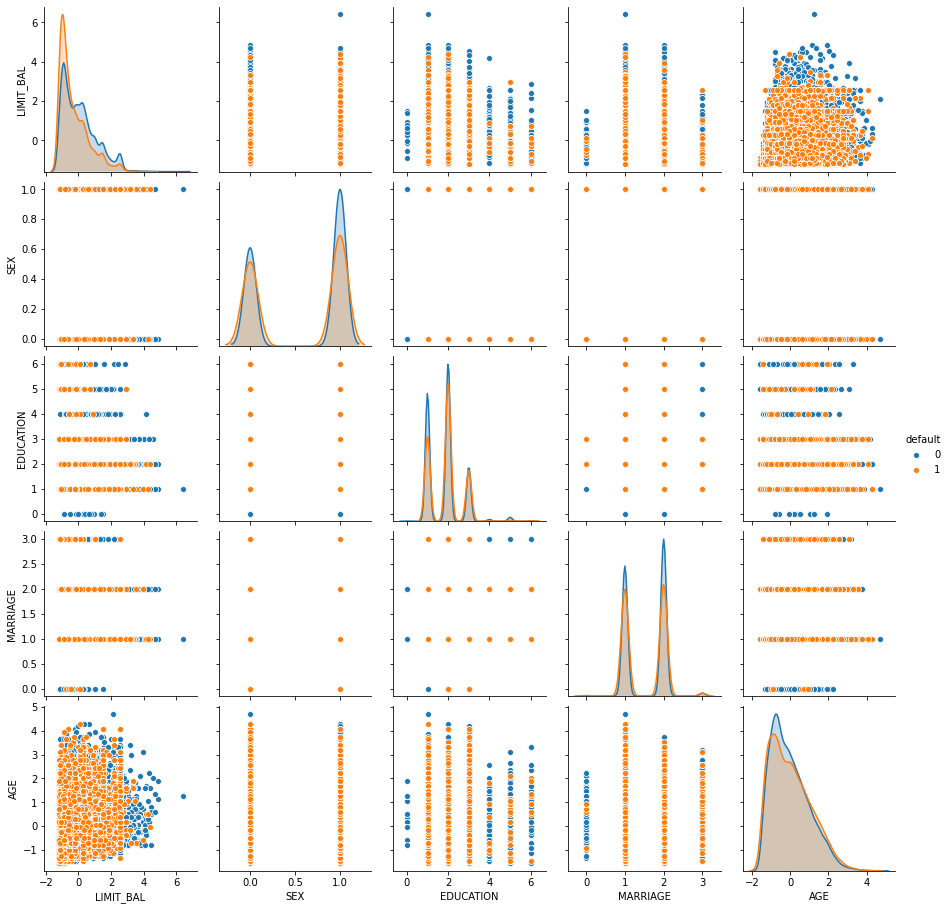

In [8]:
pairplot = sns.pairplot(data2, hue='default')

## Bayesian Logistic Regression with Variational Inference

In [7]:
with pm.Model() as model1:
    pm.glm.GLM.from_formula(formula = 'default ~ LIMIT_BAL+ SEX+ EDUCATION+ MARRIAGE+ AGE+ PAY_0+PAY_2+PAY_3+PAY_4+ PAY_5+ PAY_6+ BILL_AMT1+ BILL_AMT2+BILL_AMT3+ BILL_AMT4+ BILL_AMT5+ BILL_AMT6+ PAY_AMT1+ PAY_AMT2+ PAY_AMT3+ PAY_AMT4+ PAY_AMT5+ PAY_AMT6',
                            data=data,
                            family = pm.glm.families.Binomial()
                            )
    approx = pm.fit(50000, method = 'advi', random_seed = 1)
    #svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000),
     #                    obj_optimizer=pm.sgd(learning_rate=0.01))

Average Loss = 14,177: 100%|██████████| 50000/50000 [02:45<00:00, 302.05it/s]
Finished [100%]: Average Loss = 14,177


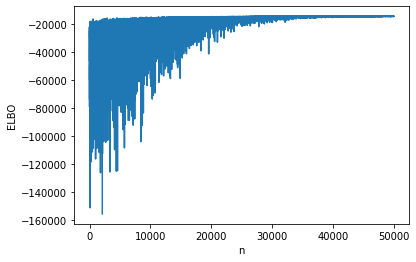

In [9]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Trace Plots

In [10]:
trace=approx.sample(10000)

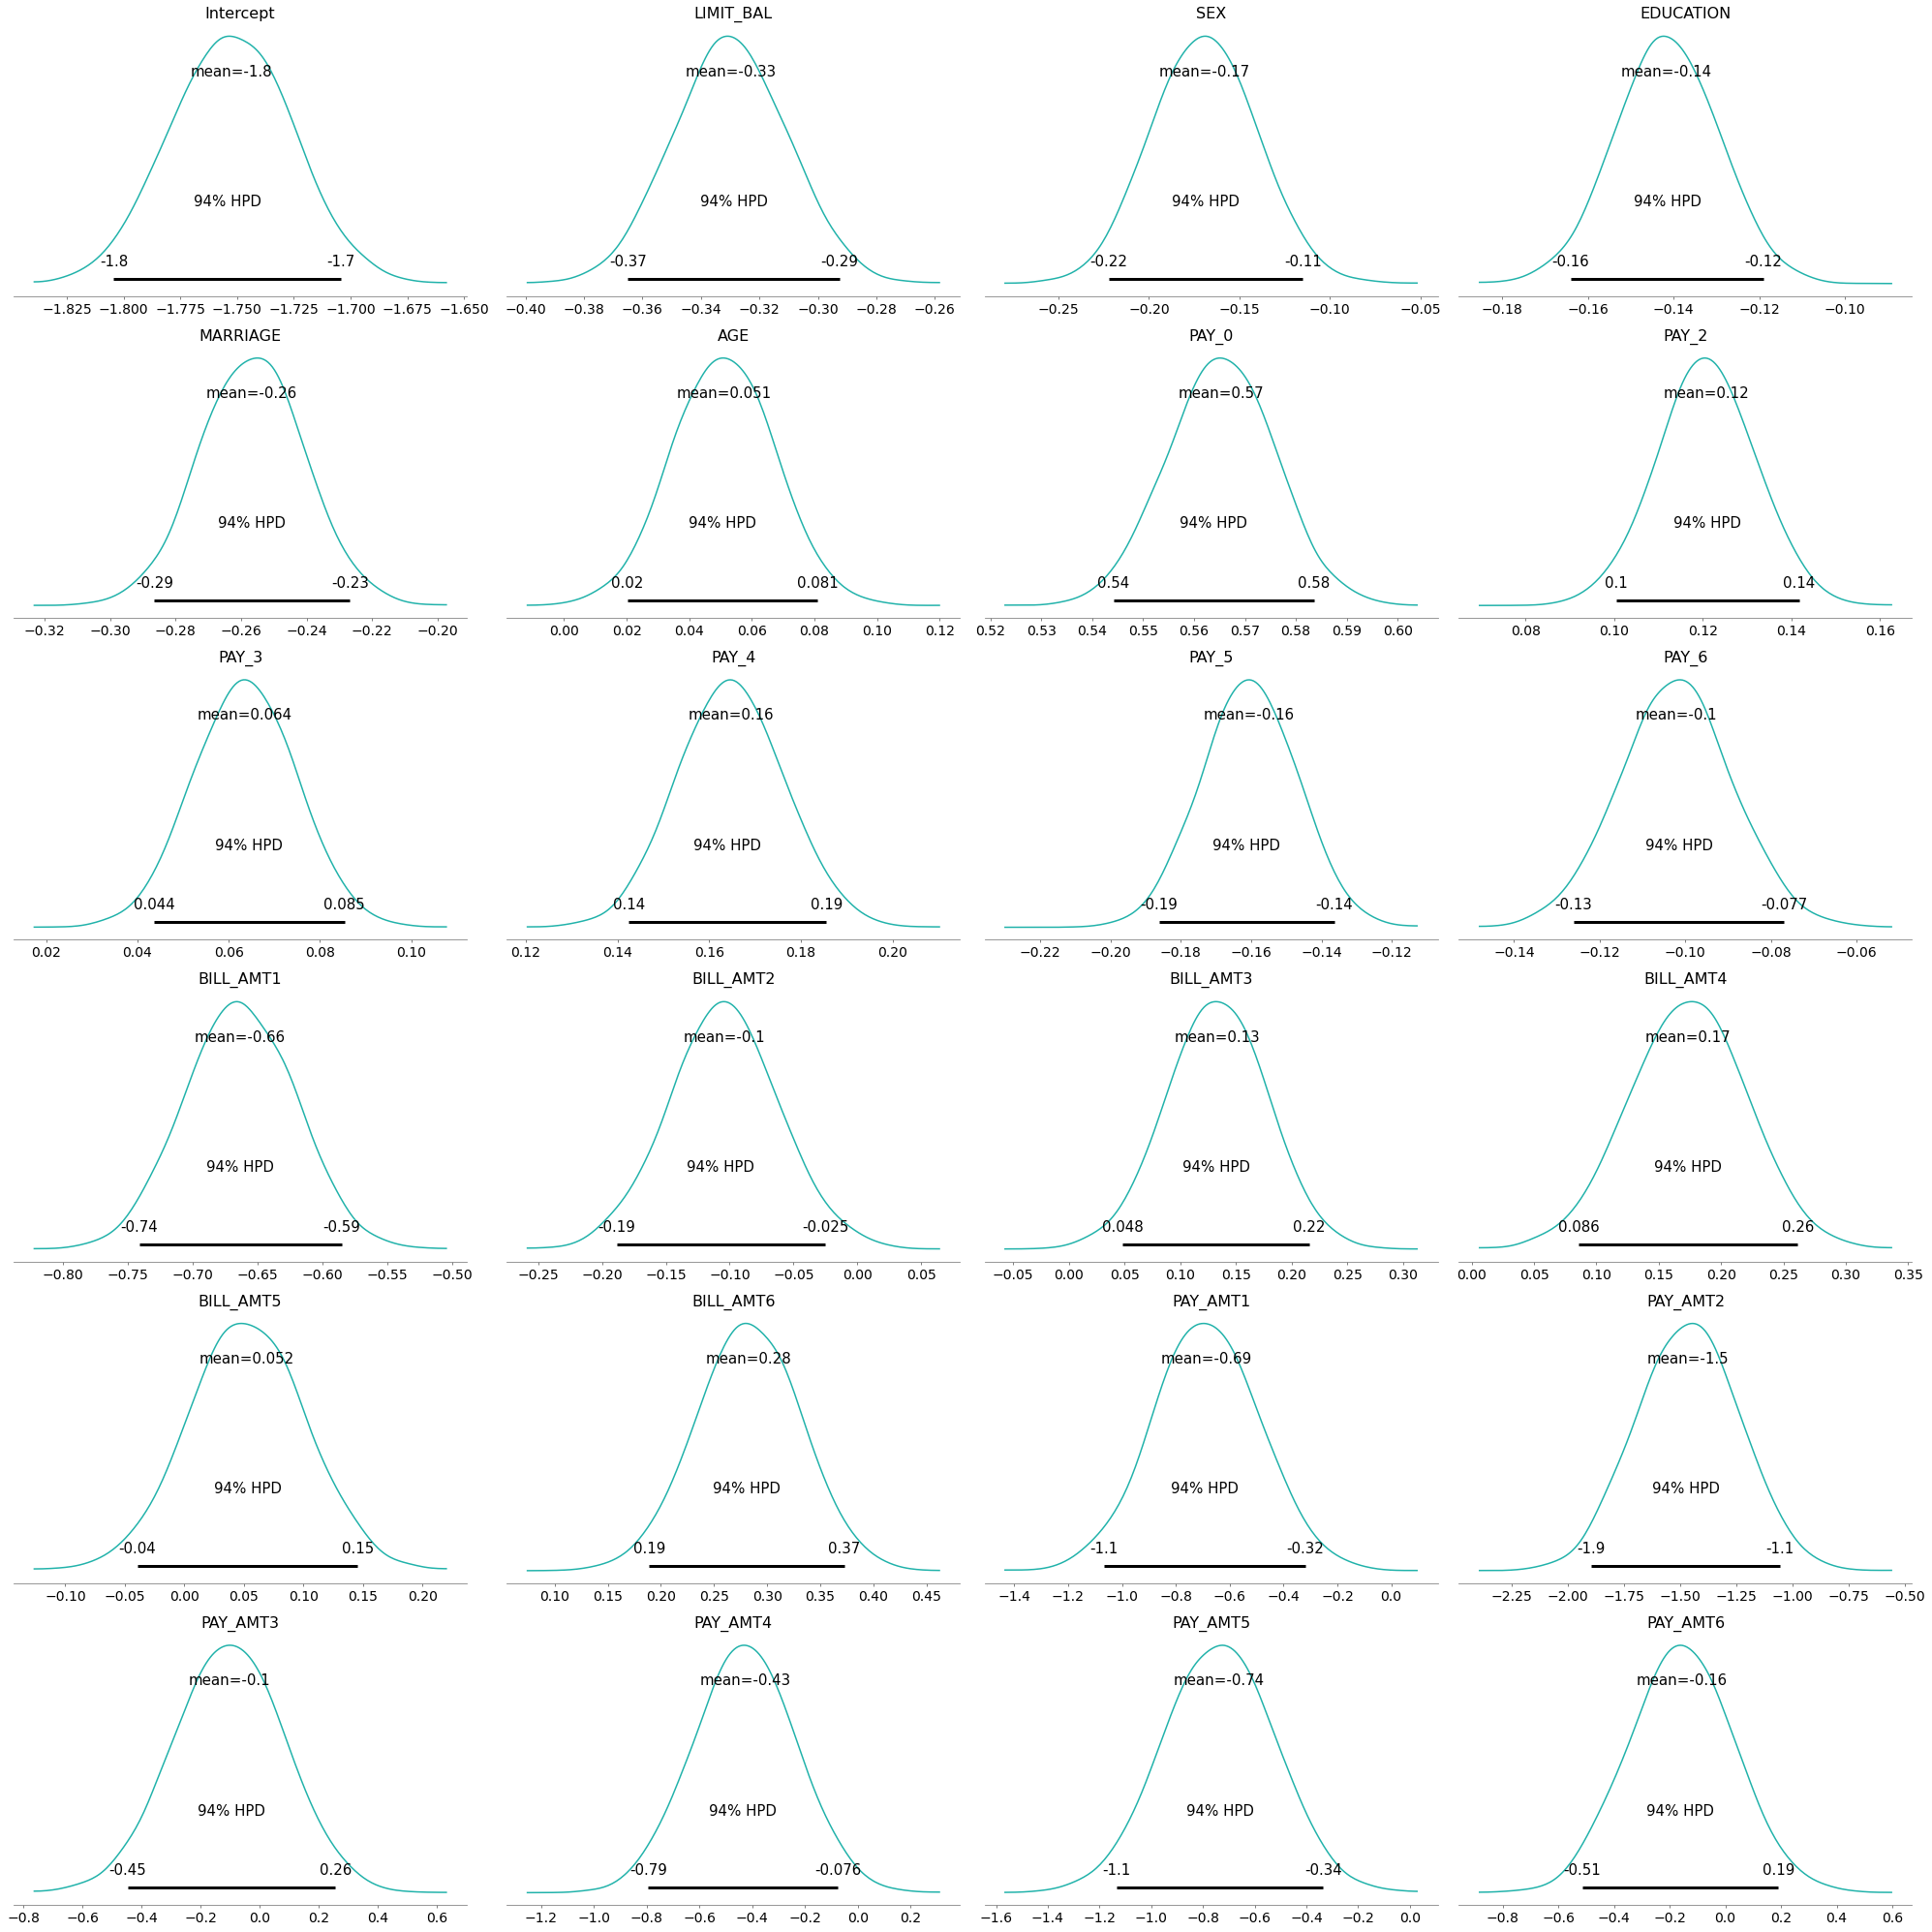

In [12]:
pm.plot_posterior(trace, color='LightSeaGreen');

## Forest Plot

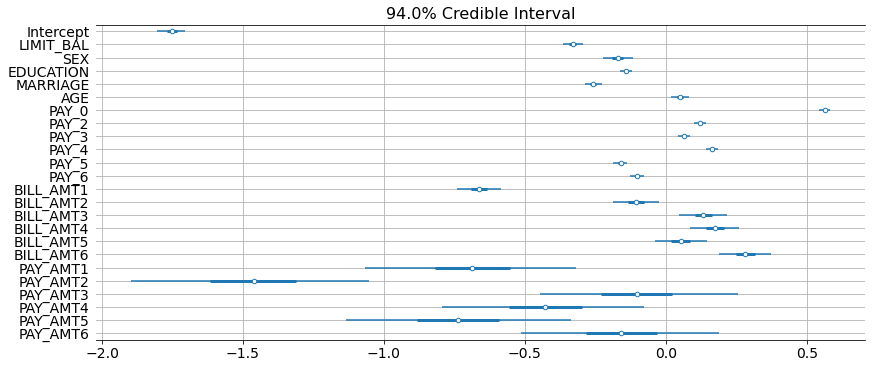

In [13]:
#forest plots
pm.plots.forestplot(trace, figsize=(12, 5))
plt.grid()  # add a grid to the plot

## Graphical Representation of the Model

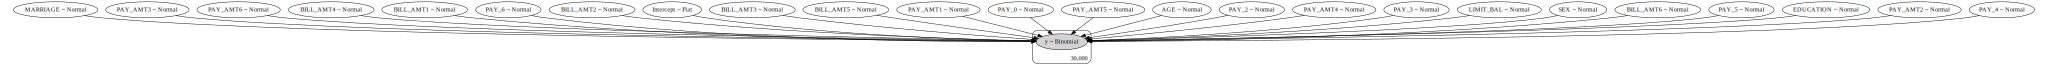

In [14]:
# Graphically display the model used for Laplace approximation
pm.model_to_graphviz(model1)

## Summary Statistics

In [22]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.754,0.027,-1.804,-1.704,0.000,0.000,9830.0,9825.0,9832.0,9609.0,NaN
LIMIT_BAL,-0.326,0.019,-0.362,-0.290,0.000,0.000,10245.0,10211.0,10250.0,9460.0,NaN
SEX,-0.167,0.030,-0.223,-0.109,0.000,0.000,9731.0,9723.0,9730.0,9600.0,NaN
EDUCATION,-0.142,0.013,-0.165,-0.117,0.000,0.000,10150.0,10150.0,10145.0,9293.0,NaN
MARRIAGE,-0.257,0.016,-0.285,-0.226,0.000,0.000,9782.0,9758.0,9783.0,9919.0,NaN
AGE,0.055,0.016,0.025,0.083,0.000,0.000,10144.0,10027.0,10142.0,9813.0,NaN
PAY_0,0.565,0.010,0.545,0.584,0.000,0.000,9895.0,9893.0,9883.0,9843.0,NaN
PAY_2,0.119,0.011,0.098,0.139,0.000,0.000,9865.0,9816.0,9866.0,9920.0,NaN
PAY_3,0.062,0.011,0.042,0.083,0.000,0.000,9405.0,9343.0,9406.0,8780.0,NaN
PAY_4,0.164,0.012,0.143,0.186,0.000,0.000,10114.0,10103.0,10128.0,9929.0,NaN


### Note:
The code in the next block comes from this source: https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

In [11]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
Intercept,-1.751,0.027,-1.804,-1.701,0.000,0.000,9213.0,9213.0,9187.0,9312.0,NaN,0.173600,-82.639974
LIMIT_BAL,-0.327,0.019,-0.362,-0.291,0.000,0.000,9490.0,9490.0,9479.0,9833.0,NaN,0.721084,-27.891626
SEX,-0.168,0.029,-0.221,-0.112,0.000,0.000,9910.0,9882.0,9917.0,9495.0,NaN,0.845354,-15.464617
EDUCATION,-0.142,0.013,-0.166,-0.117,0.000,0.000,9468.0,9468.0,9469.0,9755.0,NaN,0.867621,-13.237874
MARRIAGE,-0.258,0.016,-0.287,-0.228,0.000,0.000,10327.0,10327.0,10320.0,9837.0,NaN,0.772595,-22.740477
AGE,0.054,0.016,0.022,0.081,0.000,0.000,9839.0,9839.0,9847.0,9999.0,NaN,1.055485,5.548460
PAY_0,0.565,0.011,0.544,0.584,0.000,0.000,10467.0,10459.0,10476.0,9814.0,NaN,1.759448,75.944778
PAY_2,0.120,0.011,0.099,0.140,0.000,0.000,9013.0,9013.0,9010.0,9248.0,NaN,1.127497,12.749685
PAY_3,0.063,0.011,0.042,0.084,0.000,0.000,9133.0,9112.0,9133.0,9068.0,NaN,1.065027,6.502684
PAY_4,0.164,0.011,0.142,0.184,0.000,0.000,10230.0,10220.0,10224.0,9718.0,NaN,1.178214,17.821432


In [12]:
stat_df.loc[['Intercept', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT2', 'PAY_AMT5'],:]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
Intercept,-1.751,0.027,-1.804,-1.701,0.000,0.000,9213.0,9213.0,9187.0,9312.0,NaN,0.173600,-82.639974
LIMIT_BAL,-0.327,0.019,-0.362,-0.291,0.000,0.000,9490.0,9490.0,9479.0,9833.0,NaN,0.721084,-27.891626
SEX,-0.168,0.029,-0.221,-0.112,0.000,0.000,9910.0,9882.0,9917.0,9495.0,NaN,0.845354,-15.464617
EDUCATION,-0.142,0.013,-0.166,-0.117,0.000,0.000,9468.0,9468.0,9469.0,9755.0,NaN,0.867621,-13.237874
MARRIAGE,-0.258,0.016,-0.287,-0.228,0.000,0.000,10327.0,10327.0,10320.0,9837.0,NaN,0.772595,-22.740477
AGE,0.054,0.016,0.022,0.081,0.000,0.000,9839.0,9839.0,9847.0,9999.0,NaN,1.055485,5.548460
PAY_0,0.565,0.011,0.544,0.584,0.000,0.000,10467.0,10459.0,10476.0,9814.0,NaN,1.759448,75.944778
BILL_AMT1,-0.666,0.042,-0.745,-0.589,0.000,0.000,9691.0,9674.0,9697.0,9695.0,NaN,0.513760,-48.624049
BILL_AMT6,0.279,0.051,0.183,0.370,0.001,0.000,10205.0,10205.0,10209.0,10089.0,NaN,1.321807,32.180734
PAY_AMT2,-1.472,0.228,-1.910,-1.049,0.002,0.002,10395.0,10350.0,10390.0,9921.0,NaN,0.229466,-77.053391


/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in 

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'LIMIT_BAL'}>],
       [<AxesSubplot:title={'center':'SEX'}>,
        <AxesSubplot:title={'center':'SEX'}>],
       [<AxesSubplot:title={'center':'EDUCATION'}>,
        <AxesSubplot:title={'center':'EDUCATION'}>],
       [<AxesSubplot:title={'center':'MARRIAGE'}>,
        <AxesSubplot:title={'center':'MARRIAGE'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'AGE'}>],
       [<AxesSubplot:title={'center':'PAY_0'}>,
        <AxesSubplot:title={'center':'PAY_0'}>],
       [<AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_2'}>],
       [<AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_3'}>],
       [<AxesSubplot:title={'center':'PAY_4'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [

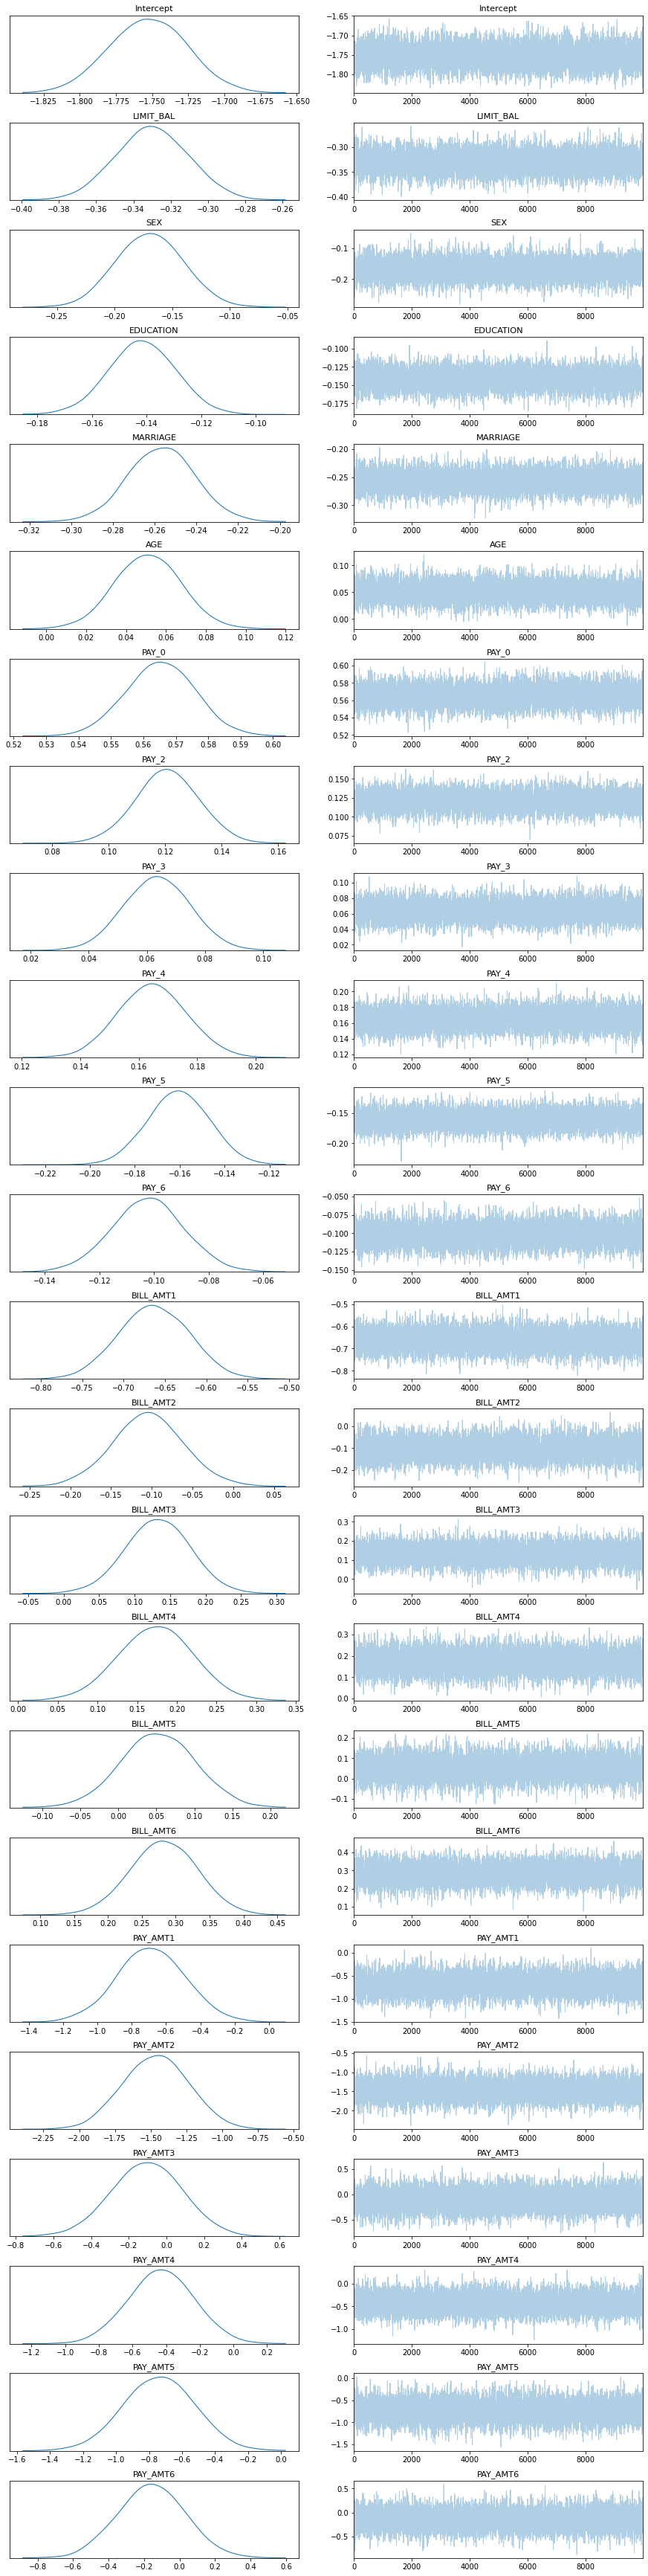

In [16]:
az.plot_trace(trace)

## Posterior Probabilities & Predictions

In [13]:
ppc = pm.sample_ppc(trace, samples=5000, model=model1)
y_score = np.mean(ppc['y'], axis=0)

/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 5000/5000 [00:20<00:00, 243.38it/s]


In [14]:
y_score

array([0.6496, 0.1398, 0.1874, ..., 0.8486, 0.225 , 0.2442])

<AxesSubplot:>

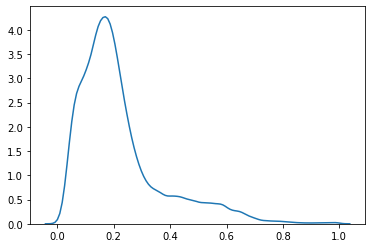

In [15]:
sns.distplot(y_score, hist=False)

In [140]:
data.default.sum()

6636

In [141]:
y_score.min()

0.0

Text(0.5, 1.0, 'Density of Probability of Default')

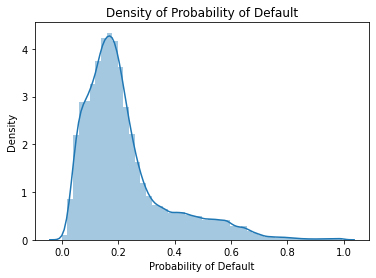

In [18]:
sns.distplot(y_score)
plt.xlabel("Probability of Default")
plt.ylabel("Density")
plt.title("Density of Probability of Default")

In [143]:
sc.describe(y_score)

DescribeResult(nobs=30000, minmax=(0.0, 0.9952), mean=0.2235056, variance=0.02368997285040168, skewness=1.5691760658507914, kurtosis=2.6188182331717353)

In [144]:
import scipy.stats as sc

In [145]:
np.sum(y_score > 0.3)

6080

In [146]:
np.sum(y_score <= 0.5)

27627

In [147]:
preds = np.where(y_score > .3, 1, 0)

In [148]:
preds

array([1, 0, 0, ..., 1, 0, 0])

In [149]:
preds.sum()

6080

In [150]:
comp = pd.DataFrame({'Predicted': preds, 'True': data.default})
comp

,Predicted,True
0,1,1
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
29995,0,0
29996,0,0
29997,1,1
29998,0,1


## Confusion Matrix

In [151]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(data.default, preds)
array

array([[20544,  2820],
       [ 3376,  3260]])

<AxesSubplot:>

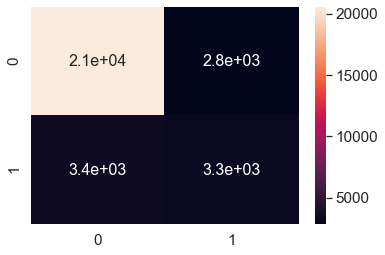

In [152]:
df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
# sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

## ROC Curve 

In [11]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 

### Note:
This code comes from this source: http://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

In [12]:
X = data.drop('default', axis=1)
y = data.default
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
labels = X_train.columns

X_shared = thno.shared(X_train.values)

In [13]:
with pm.Model() as model2:
    pm.glm.GLM(x=X_shared, labels=labels,
               y=y_train, family=pm.glm.families.Binomial())

    approx = pm.fit(50000, method = 'advi', random_seed = 1)

Average Loss = 11,391: 100%|██████████| 50000/50000 [02:19<00:00, 358.69it/s]
Finished [100%]: Average Loss = 11,391


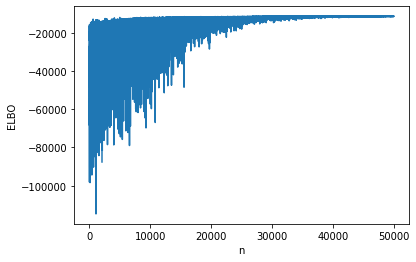

In [14]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [15]:
trace=approx.sample(10000)

In [17]:
X_shared.set_value(X_test)

ppc = pm.sample_ppc(trace,
                    model=model2,
                    samples=100)

/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
/Users/jmachita03/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 213.92it/s]


In [18]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

0.721858485925729

In [19]:
pred_scores = dict(y_true=y_test, y_score=y_score)
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [20]:
precision, recall, ts = precision_recall_curve(y_true=y_test, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

In [21]:
f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

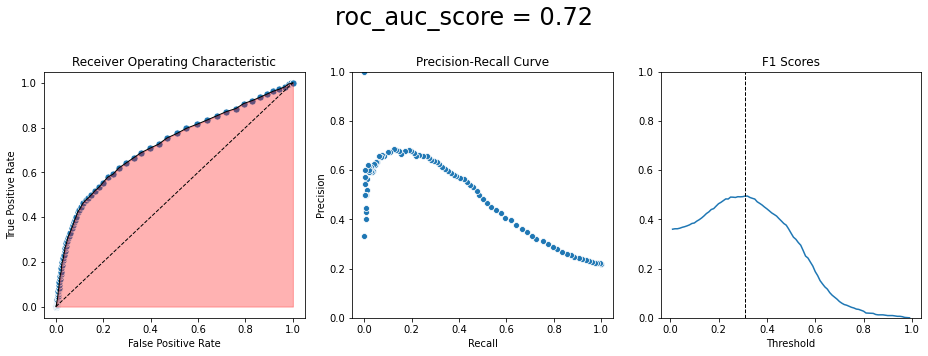

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, s=50, legend=False, ax=axes[0])
axes[0].plot('False Positive Rate', 'True Positive Rate', data=roc, lw=1, color='k')
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.3, color='red')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
#axes[2].text(text=f'Max F1 @ {best_threshold:.2f}', x=.60, y=.95, s=5)
fig.suptitle(f'roc_auc_score = {round(roc_auc_score(**pred_scores),2)}', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8)
plt.show();